<a href="https://colab.research.google.com/github/brainhack-school2020/BHS-AuditoryMultimodal/blob/master/BHS_AuditoryMultimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auditory Multimodal

Add description of what is going on.

In [1]:
import pandas as pd
from os.path import join

from nipype.interfaces.io import BIDSDataGrabber
from nipype.pipeline import Node, MapNode, Workflow
from nipype.interfaces.utility import Function

from bids import BIDSLayout
from bids.reports import BIDSReport
from bids_validator import BIDSValidator

from nilearn import datasets
from nilearn import plotting
from nilearn import image
from nilearn.image import mean_img
from nilearn.masking import apply_mask
from nilearn.input_data import NiftiMasker
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

import numpy as np

# from nistats.first_level_model import FirstLevelModel

import glob
from pathlib import Path
import itertools

200604-00:10:16,592 nipype.utils INFO:
	 Running nipype version 1.4.2 (latest: 1.5.0)


In [26]:
run_long_processing= False

## Preprocess data using fmriprep

`fmriprep-docker --fs-license-file /home/marcel/Documents/license.txt -vv --use-syn-sdc --use-aroma --resource-monitor --low-mem -w '/home/marcel/fmriprep-wd/wd' '/home/marcel/fmriprep-wd/ds000171-download' '/home/marcel/fmriprep-wd/ds000171-download/derivatives' participant`


In [2]:
# Load atlas

parcellations = datasets.fetch_atlas_basc_multiscale_2015(version='sym')
atlas_filename = parcellations.scale064

print('Atlas ROIs are located in nifti image (4D) at: %s' %
       atlas_filename)

Atlas ROIs are located in nifti image (4D) at: /home/marcel/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz


In [3]:
data_folder = '/home/marcel/fmriprep-wd/ds000171-download'
data_folder_pp = '/home/marcel/fmriprep-wd/ds000171-download/derivatives/fmriprep'

# Validate the input data
BIDSValidator().is_bids(data_folder)

False

After running fmriprep, bids does not recognise its output

adding ./derivatives to .bidsignore

# Check layout using BIDSLayout

In [4]:
layout = BIDSLayout(data_folder)

print(layout)
print(layout.get_subjects())
print(layout.get_modalities())
# print(layout.get_types())
print(layout.get_tasks())
layout.get( return_type='file')


BIDS Layout: .../fmriprep-wd/ds000171-download | Subjects: 1 | Sessions: 0 | Runs: 5
['control01']
[]
['music', 'nonmusic']


['/home/marcel/fmriprep-wd/ds000171-download/CHANGES',
 '/home/marcel/fmriprep-wd/ds000171-download/dataset_description.json',
 '/home/marcel/fmriprep-wd/ds000171-download/participants.tsv',
 '/home/marcel/fmriprep-wd/ds000171-download/README',
 '/home/marcel/fmriprep-wd/ds000171-download/sub-control01/anat/sub-control01_T1w.nii.gz',
 '/home/marcel/fmriprep-wd/ds000171-download/sub-control01/func/sub-control01_task-music_run-1_bold.nii.gz',
 '/home/marcel/fmriprep-wd/ds000171-download/sub-control01/func/sub-control01_task-music_run-1_events.tsv',
 '/home/marcel/fmriprep-wd/ds000171-download/sub-control01/func/sub-control01_task-music_run-2_bold.nii.gz',
 '/home/marcel/fmriprep-wd/ds000171-download/sub-control01/func/sub-control01_task-music_run-2_events.tsv',
 '/home/marcel/fmriprep-wd/ds000171-download/sub-control01/func/sub-control01_task-music_run-3_bold.nii.gz',
 '/home/marcel/fmriprep-wd/ds000171-download/sub-control01/func/sub-control01_task-music_run-3_events.tsv',
 '/home/marce

In [5]:
# !tree -L 4 data_folder_pp

# Extract data using BIDSDataGrabber

In [6]:
useAll= False
useNSubj = 2

if useAll:
    subjIDs = layout.get_subjects()
else:
    subjIDs = layout.get_subjects()[:useNSubj]

bg = Node(BIDSDataGrabber(), name='bids-grabber')
bg.inputs.base_dir = data_folder
bg.iterables = ('subject', subjIDs)
res = bg.run()
res.outputs

200604-00:10:18,39 nipype.workflow INFO:
	 [Node] Setting-up "bids-grabber" in "/tmp/tmptbmbjq6r/bids-grabber".


INFO:nipype.workflow:[Node] Setting-up "bids-grabber" in "/tmp/tmptbmbjq6r/bids-grabber".


200604-00:10:18,46 nipype.workflow INFO:
	 [Node] Running "bids-grabber" ("nipype.interfaces.io.BIDSDataGrabber")


INFO:nipype.workflow:[Node] Running "bids-grabber" ("nipype.interfaces.io.BIDSDataGrabber")


200604-00:10:18,250 nipype.workflow INFO:
	 [Node] Finished "bids-grabber".


INFO:nipype.workflow:[Node] Finished "bids-grabber".



T1w = ['/home/marcel/fmriprep-wd/ds000171-download/sub-control01/anat/sub-control01_T1w.nii.gz']
bold = ['/home/marcel/fmriprep-wd/ds000171-download/sub-control01/func/sub-control01_task-music_run-1_bold.nii.gz', '/home/marcel/fmriprep-wd/ds000171-download/sub-control01/func/sub-control01_task-music_run-2_bold.nii.gz', '/home/marcel/fmriprep-wd/ds000171-download/sub-control01/func/sub-control01_task-music_run-3_bold.nii.gz', '/home/marcel/fmriprep-wd/ds000171-download/sub-control01/func/sub-control01_task-nonmusic_run-4_bold.nii.gz', '/home/marcel/fmriprep-wd/ds000171-download/sub-control01/func/sub-control01_task-nonmusic_run-5_bold.nii.gz']

frmiprep output is incompatible with the current bids standar, we will need to load the thigs maually

(80, 80, 50, 105)
/home/marcel/fmriprep-wd/ds000171-download/sub-control01/func/sub-control01_task-music_run-1_bold.nii.gz


/home/marcel/miniconda3/lib/python3.7/site-packages/nilearn/image/resampling.py:513: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))



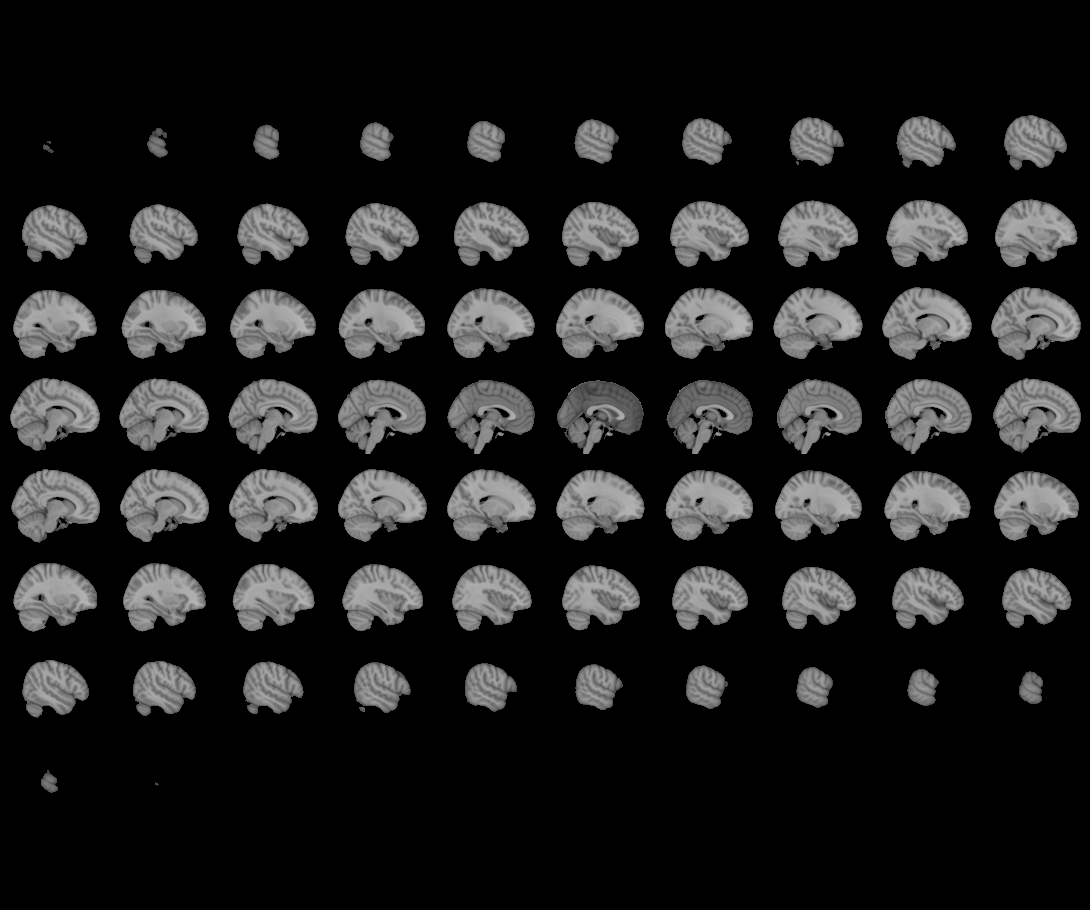
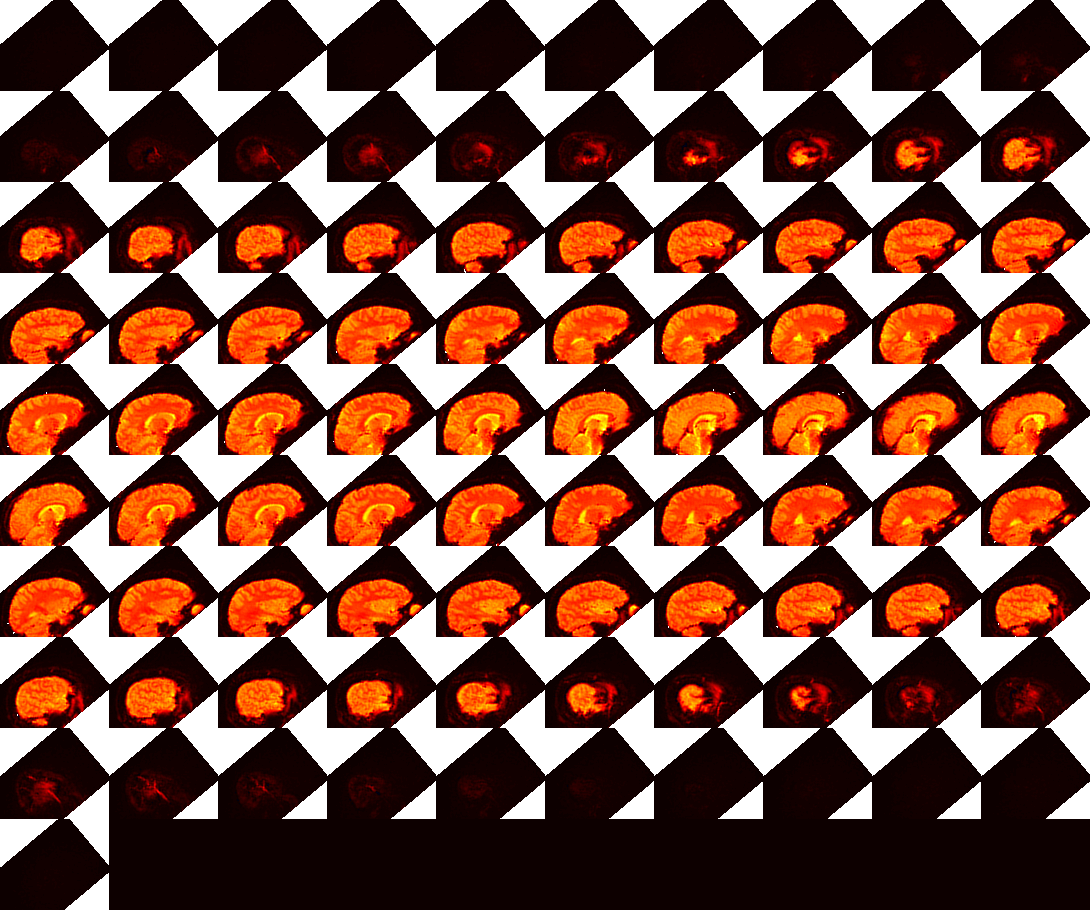

In [7]:
what_to_load = res.outputs.bold[0]

print(image.load_img(what_to_load).shape)

print(what_to_load)
example = image.index_img(what_to_load, 1)

example = image.index_img(what_to_load, 0)
plotting.view_img(example)
# plotting.view_img(example)
# Crash, report issue to git repo
# plotting.plot_stat_map(example)

# from nilearn.input_data import NiftiMasker
# masker = NiftiMasker(standardize=True, detrend=True)
# masker.fit(what_to_load)
# NiftiMasker(detrend=True, standardize=True)
# data = masker.transform(what_to_load)

Try to load the derivaties ... 

As we see using glass brain, this data is not aligned with the template

/home/marcel/miniconda3/lib/python3.7/site-packages/nilearn/image/resampling.py:513: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


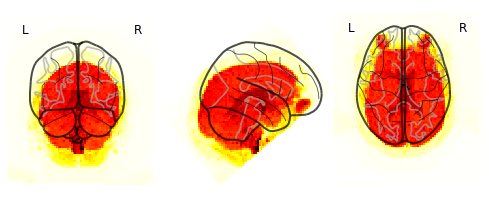

In [8]:
plotting.plot_glass_brain(example, threshold=3)

Processing sub /home/marcel/fmriprep-wd/ds000171-download/derivatives/fmriprep/sub-control01
We are processing: sub-control01_task-music_run-1_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz with confounds sub-control01_task-music_run-1_desc-confounds_regressors.tsv
[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Resampling mask
We are processing: sub-control01_task-music_run-2_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz with confounds sub-control01_task-music_run-2_desc-confounds_regressors.tsv
[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.fit] Resampling mask
We are processi

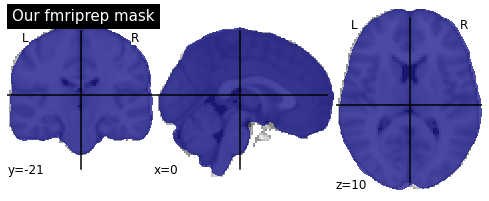

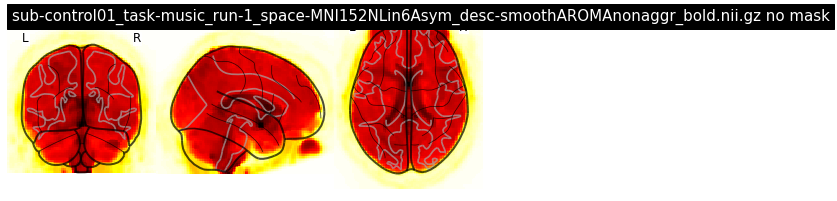

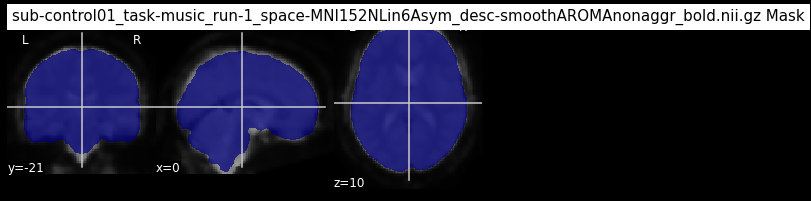

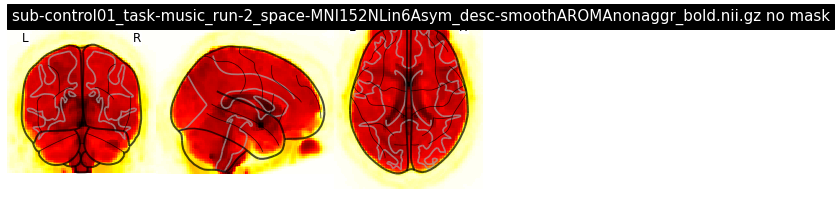

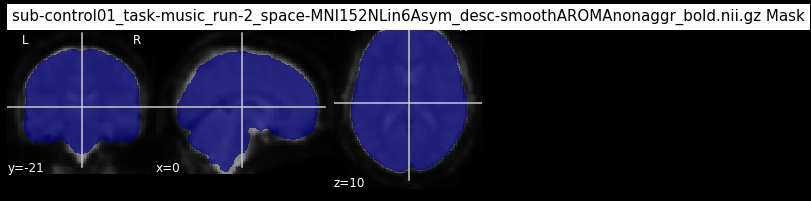

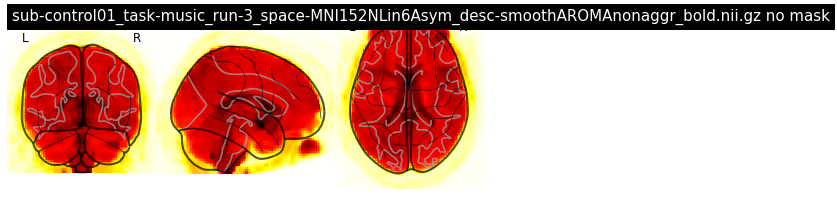

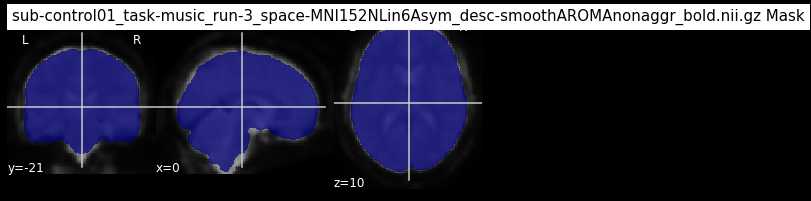

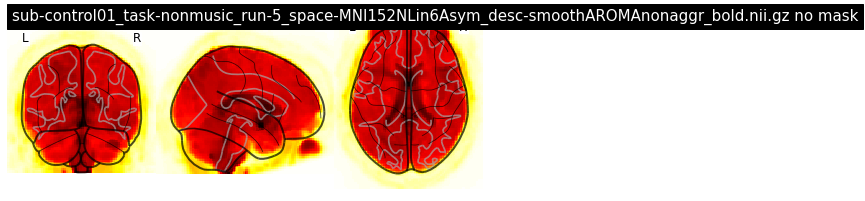

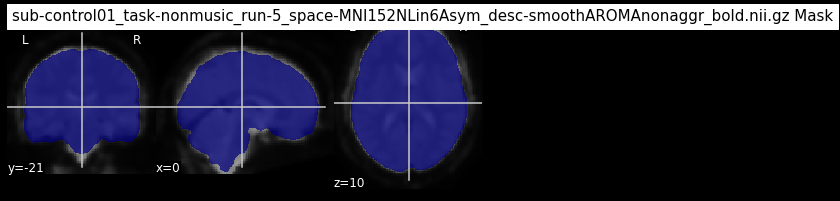

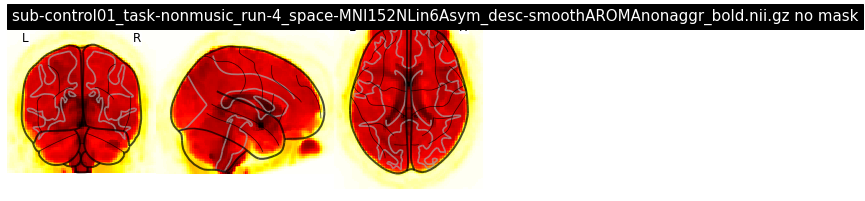

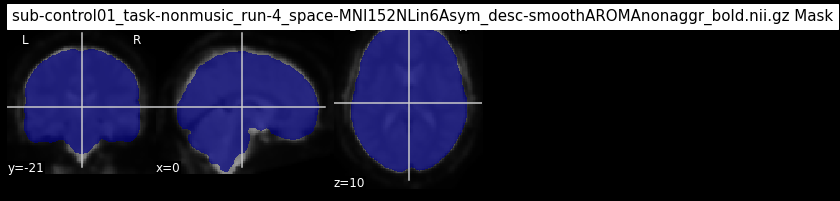

In [9]:
mus_run = 'task-music'
nonmus_run = 'task-nonmusic'

list_confounds = ['csf', 'white_matter', 'global_signal', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'cosine00', 'cosine01', 'cosine02']

subjects_control = glob.glob(data_folder_pp+'/'+'sub-control*')
subjects_mdd = glob.glob(data_folder_pp+'/'+'sub-mdd*')

# Example file name
# sub-control01_task-nonmusic_run-5_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold
for s in subjects_control:
    # load brain mask
    
    if Path(s).is_dir() is False:
        continue
    
    print('Processing sub '+s)
    try:
        mask_file = next(Path(s).rglob('*_space-MNI152NLin6Asym_desc-brain_mask.nii.gz'))
    except StopIteration:
        mask_file = ''
        print('mask file not found!')
        break
    
#     print(mask_file)  

    plotting.plot_roi(str(mask_file), title='Our fmriprep mask')
    
    images = sorted(Path(s).rglob('*'+mus_run +'_*_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz'))
    confound_file = sorted(Path(s).rglob('*'+mus_run +'_*_desc-confounds_regressors.tsv'))

    for img, c_file in zip(images, confound_file):
        print(f'We are processing: {img.name} with confounds {c_file.name}')

        # print first volume
        # plotting.plot_glass_brain(image.index_img(str(img), 0), threshold=5)

        img_mean = mean_img(str(img))

        plotting.plot_glass_brain(img_mean, threshold=None, title=img.name+' no mask')
        
        masker = NiftiMasker(mask_img=str(mask_file), standardize=True, verbose=5)
        # img_mean_mask = masker.fit(img_mean)
        masker.fit(img_mean)
        
        plotting.plot_roi(masker.mask_img_, img_mean, title=img.name+' Mask')
        
#         report = masker.generate_report()
#         report
        
    images = Path(s).rglob('*'+nonmus_run +'_*_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz')
    for img in images:
        print(f'We are processing: {img.name} with confounds {c_file.name}')

        # print first volume
        # plotting.plot_glass_brain(image.index_img(str(img), 0), threshold=5)

        img_mean = mean_img(str(img))

        plotting.plot_glass_brain(img_mean, threshold=None, title=img.name+' no mask')
        
        masker = NiftiMasker(mask_img=str(mask_file), standardize=True, verbose=5)
        # img_mean_mask = masker.fit(img_mean)
        masker.fit(img_mean)
        
        plotting.plot_roi(masker.mask_img_, img_mean, title=img.name+' Mask')
        
#         report = masker.generate_report()
#         report

# Basic functional connectome

In [36]:
def process_subject(subj_folder, condition_name, list_confounds, atlas_filename):

    # load brain mask
    print('Processing sub '+subj_folder)
    try:
        mask_file = next(Path(subj_folder).rglob('*_space-MNI152NLin6Asym_desc-brain_mask.nii.gz'))
    except StopIteration:
        mask_file = ''
        print('mask file not found!')
        return 
    

    plotting.plot_roi(str(mask_file), title='Our fmriprep mask')
    
    images = sorted(Path(s).rglob('*'+mus_run +'_*_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz'))
    confound_file = sorted(Path(s).rglob('*'+mus_run +'_*_desc-confounds_regressors.tsv'))
    events_file = sorted(Path(s).rglob('*'+mus_run +'_*_events.tsv'))

    all_confounds = []
    all_images = []
    all_events = []
    all_time_series = []
    
    for img, c_file, e_file in zip(images, confound_file, events_file):
        print(f'We are processing: {img.name} with confounds {c_file.name} and events file {e_file}')

        # load confounds
        confounds = pd.read_csv(c_file, delimiter = '\t')
        final_confounds = confounds[list_confounds]
        # Convert into a numpy as required by Nilearn
        all_confounds.append(final_confounds.to_numpy())\
        
        # load events
        events = pd.read_csv(e_file, delimiter = '\t')
        all_events.append(events)
        
        all_images.append(str(img))
    
    time_series =[]
    time_series_atlas = []
    
    time_series = do_time_series(mask_file, all_images, all_confounds)
    time_series_atlas = do_time_series_atlas(all_images, atlas_filename, all_confounds)
        
    return time_series, time_series_atlas

def do_time_series_atlas(imgs, atlas_filename, confounds_np):
    
    masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,
                               memory='nilearn_cache', verbose=5)
    time_series = []
    for func, confounds in zip(imgs, confounds_np):
        time_series.append(masker.fit_transform(func, confounds=confounds))
    # time_series_atlas = masker.fit_transform(imgs, confounds=confounds_np)
    
    return time_series

def do_corr_matrix_mean(time_series):
    
    connectome_measure = ConnectivityMeasure(kind='correlation')
    
    correlation_matrices = connectome_measure.fit_transform(time_series)
    
    mean_correlation_matrix = connectome_measure.mean_
    
    return mean_correlation_matrix

def plot_conn (time_series):
    correlation_measure = ConnectivityMeasure(kind='correlation')
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    np.fill_diagonal(correlation_matrix, 0)
    
    plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=atlas_filename,
                     vmax=0.8, vmin=-0.8, reorder=True)

def plot_corr_matrix (mean_correlation_matrix, atlas_filename):
    
    # grab center coordinates for atlas labels
    coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_filename)

    # plot connectome with 80% edge strength in the connectivity
    plotting.plot_connectome(mean_correlation_matrix, coordinates,
                             edge_threshold="80%",
                             title='atlas_filename')

def do_time_series(mask_file, imgs, confounds_np):
    masker = NiftiMasker(mask_img=str(mask_file), standardize=True, verbose=5)
    
    time_series = []
    for func, confounds in zip(imgs, confounds_np):
        tmp_t_s = masker.fit_transform(func, confounds=confounds)
        print(f'Time seires shape is {tmp_t_s.shape}')
        print(tmp_t_s)
        time_series.append(tmp_t_s)

    report = masker.generate_report()
#     print(report)

    return time_series

Processing sub /home/marcel/fmriprep-wd/ds000171-download/derivatives/fmriprep/sub-control01
We are processing: sub-control01_task-music_run-1_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz with confounds sub-control01_task-music_run-1_desc-confounds_regressors.tsv and events file /home/marcel/fmriprep-wd/ds000171-download/derivatives/fmriprep/sub-control01/func/sub-control01_task-music_run-1_events.tsv
We are processing: sub-control01_task-music_run-2_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz with confounds sub-control01_task-music_run-2_desc-confounds_regressors.tsv and events file /home/marcel/fmriprep-wd/ds000171-download/derivatives/fmriprep/sub-control01/func/sub-control01_task-music_run-2_events.tsv
We are processing: sub-control01_task-music_run-3_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz with confounds sub-control01_task-music_run-3_desc-confounds_regressors.tsv and events file /home/marcel/fmriprep-wd/ds000171-download/derivatives/fm

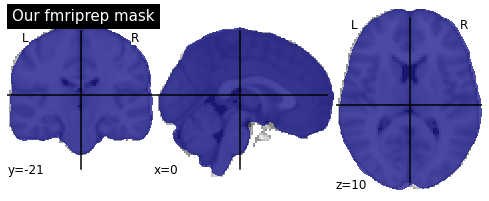

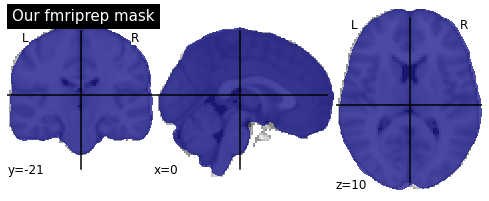

In [11]:
mus_run = 'task-music'
nonmus_run = 'task-nonmusic'

output_df_mask = 'mask_control.csv'

list_confounds = ['csf', 'white_matter', 'global_signal', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'cosine00', 'cosine01', 'cosine02']

subjects_control = glob.glob(data_folder_pp+'/'+'sub-control*')
subjects_mdd = glob.glob(data_folder_pp+'/'+'sub-mdd*')

# df = pd.DataFrame(data={'time_series':[], 'labels':[], 'mask_file': [], 'img_file': []})

# Example file name
# sub-control01_task-nonmusic_run-5_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold
time_series_mus= []
time_series_atlas_mus = []

time_series_nonmus= []
time_series_atlas_nonmus = []

for s in subjects_control:
    if Path(s).is_dir() is False or run_long_processing is False:
        continue
    
    tmp_time_series, tmp_time_series_atlas = process_subject(s, mus_run, list_confounds, atlas_filename)
    time_series_mus.append(tmp_time_series)
    time_series_atlas_mus.append(tmp_time_series_atlas)

    
for s in subjects_control:
    if Path(s).is_dir() is False or  or run_long_processing is False:
        continue
    
    tmp_time_series, tmp_time_series_atlas =  process_subject(s, nonmus_run, list_confounds, atlas_filename)
    time_series_nonmus.append(tmp_time_series)
    time_series_atlas_nonmus.append(tmp_time_series_atlas)

    

# dt.to_csv(output_df_mask, sep='\t')

In [33]:
outfolder = 'outdata'
p = Path(outfolder).mkdir( exist_ok=True)

if run_long_processing is False:
    # Save the data
    np.save(Path(outfolder, 'time_series_mus'), time_series_mus)
    np.save(Path(outfolder,'time_series_atlas_mus'), time_series_mus)
    np.save(Path(outfolder,'time_series_nonmus'), time_series_mus)
    np.save(Path(outfolder,'time_series_atlas_nonmus'), time_series_mus)
else:
    # Load the data
    time_series_mus =np.load(Path(outfolder, 'time_series_mus'))
    time_series_mus = np.load(Path(outfolder,'time_series_atlas_mus'))
    time_series_mus = np.load(Path(outfolder,'time_series_nonmus'), )
    time_series_mus = np.load(Path(outfolder,'time_series_atlas_nonmus'), )
else:


In [1]:
mean_correlation_matrix = do_corr_matrix_mean(np.array(time_series_mus))

plot_corr_matrix (mean_correlation_matrix, atlas_filename)


NameError: name 'do_corr_matrix_mean' is not defined

In [ ]:
t =(['mus_run'] * 4)
np.array(t)

In [ ]:
# Create 


for s in subjects_control:
    
    if Path(s).is_dir() is False:
        continue
    
    print('Processing sub '+s)
    
    images = Path(s).rglob('*'+mus_run+'*'+'.nii.gz')
    events = Path(s).rglob('*'+mus_run+'*'+'.tsv')
    for img, c_file in zip(images, events):

        print(img.name)
    for ev in events:
        print(ev.name)
#         plotting.plot_glass_brain(image.index_img(str(img), 0), threshold=5)
#         # ploting mean
#         img_mean = mean_img(str(img))
#         print(img_mean.shape)
#         plotting.plot_glass_brain(img_mean, threshold=None, )
        
        
#         df.append({'img':str(img), 'events':[]})
        
#     images = Path(s).rglob('*'+nonmus_run +'_*_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz')
#     for img in images:
#         print(img.name)
#         # print first volume
#         # plotting.plot_glass_brain(image.index_img(str(img), 0), threshold=5)
#         # ploting mean
#         img_mean = mean_img(str(img))
#         print(img_mean.shape)
#         plotting.plot_glass_brain(img_mean, threshold=None, )
        
#         # print masked first volume
#         # does not work for now (mask and func data diffenret size)
#         # masked_data = _apply_mask(str(img), str(mask_file))

In [ ]:
from nilearn.datasets import fetch_haxby
data_files = fetch_haxby()

# Load behavioral data
import pandas as pd
behavioral = pd.read_csv(data_files.session_target[0], sep=" ")

# Restrict to face and house conditions
conditions = behavioral['labels']
condition_mask = conditions.isin(['face', 'house'])

# Split data into train and test samples, using the chunks
condition_mask_train = (condition_mask) & (behavioral['chunks'] <= 6)
condition_mask_test = (condition_mask) & (behavioral['chunks'] > 6)

# Apply this sample mask to X (fMRI data) and y (behavioral labels)
# Because the data is in one single large 4D image, we need to use
# index_img to do the split easily
from nilearn.image import index_img
func_filenames = data_files.func[0]
X_train = index_img(func_filenames, condition_mask_train)
X_test = index_img(func_filenames, condition_mask_test)
y_train = conditions[condition_mask_train]
y_test = conditions[condition_mask_test]

# Compute the mean epi to be used for the background of the plotting
from nilearn.image import mean_img
background_img = mean_img(func_filenames)

In [ ]:
condition_mask_train
func_filenames

In [ ]:
from nilearn import datasets

yeo = datasets.fetch_atlas_yeo_2011()
print('Yeo atlas nifti image (3D) with 17 parcels and liberal mask is located '
      'at: %s' % yeo['thick_17'])

data = datasets.fetch_development_fmri(n_subjects=10)

print('Functional nifti images (4D, e.g., one subject) are located at : %r'
      % data['func'][0])
print('Counfound csv files (of same subject) are located at : %r'
      % data['confounds'][0])


# ConenctivityMeasure from Nilearn uses simple 'correlation' to compute
# connectivity matrices for all subjects in a list
connectome_measure = ConnectivityMeasure(kind='correlation')

# useful for plotting connectivity interactions on glass brain
from nilearn import plotting

# create masker to extract functional data within atlas parcels
masker = NiftiLabelsMasker(labels_img=yeo['thick_17'], standardize=True,
                           memory='nilearn_cache')

# extract time series from all subjects and concatenate them
time_series = []
for func, confounds in zip(data.func, data.confounds):
    time_series.append(masker.fit_transform(func, confounds=confounds))

# calculate correlation matrices across subjects and display
correlation_matrices = connectome_measure.fit_transform(time_series)

# Mean correlation matrix across 10 subjects can be grabbed like this,
# using connectome measure object
mean_correlation_matrix = connectome_measure.mean_

# grab center coordinates for atlas labels
coordinates = plotting.find_parcellation_cut_coords(labels_img=yeo['thick_17'])

# plot connectome with 80% edge strength in the connectivity
plotting.plot_connectome(mean_correlation_matrix, coordinates,
                         edge_threshold="80%",
                         title='Yeo Atlas 17 thick (func)')